## Imports and Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Function Definitions

In [3]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [4]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [5]:
def output_spectrum_with_input(ω, κ, γ, r, g, Δ, nT, nc, ns, nb=0):
    """
    Function for calculation the output spectrum of the NV ensemble using input/output theory with a noisy input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param ns: the number of photons in the input field
    :param nb: the number of photons in the input field due to noise (this might be extra - nT should handle it just fine?)
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator
    a = (r ** 2 / 4 + ω ** 2) * (κ ** 2 * (ns + nb) + κ * γ * nT)
    b = r * g ** 2 * nc
    c = np.abs(((κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 * nT
    num = a + b + c

    # Define the denominator
    d = ((κ + γ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω)
    e = g ** 2
    den = np.abs(d + e) ** 2

    return num / den

## Initial Testing

In [6]:
# First define the usual parameters - we'll start at room temperature for now
ωc = 2.87 * 2 * np.pi * 1e9
g = 2 * np.pi * 197.7e3
r = 2 * np.pi * 229e3
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)

First test is to see if we can successfully recreate the output spectrum plot if we have 0 extra input

In [7]:
# Define the values of ω and Δ that we need
ω = np.linspace(-1.5, 1.5, 1000) * 2 * np.pi * 1e6
Δ = np.linspace(-4, 4, 1000) * 2 * np.pi * 1e6

# Create the meshgrid
ωm, Δm = np.meshgrid(ω, Δ)

In [8]:
# Now calculate the output spectrum
output_spec = output_spectrum_with_input(ωm, κ, γ, r, g, Δm, nT, nc, 0)

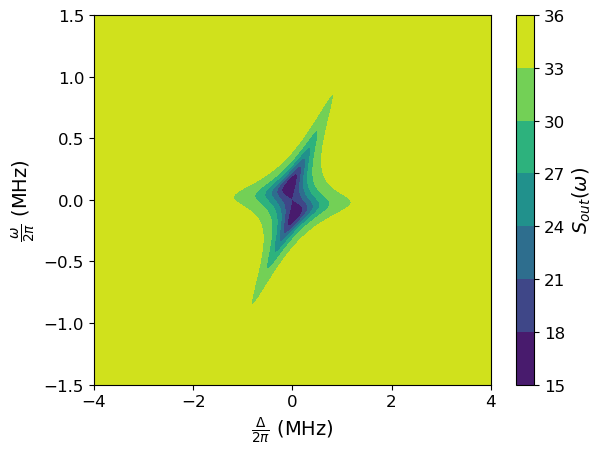

In [9]:
# And plot
plt.contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec)
plt.xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
plt.ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.colorbar(label="$S_{out}(\\omega)$")

Now introduce a non-zero field and see what happens.  We'll use $n_s = 100$ to start.

In [10]:
# Define the input field photon number
ns = 100

In [11]:
output_spec = output_spectrum_with_input(ωm, κ, γ, r, g, Δm, nT, nc, ns, 0)

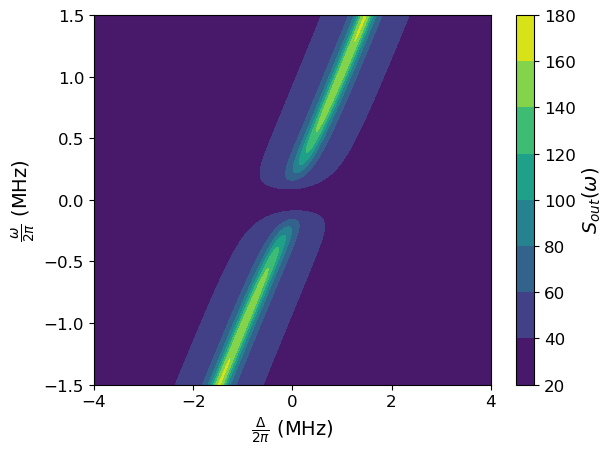

In [12]:
# And plot
plt.contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec)
plt.xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
plt.ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.colorbar(label="$S_{out}(\\omega)$")

In [13]:
output_spec_no_cooling = output_spectrum_with_input(ωm, κ, γ, 0, 0, Δm, nT, nc, ns, 0)

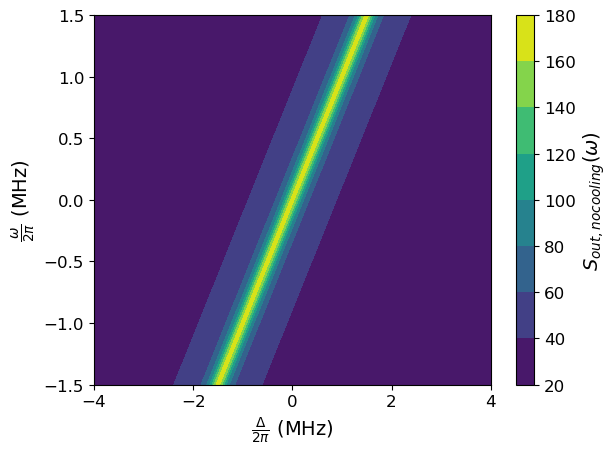

In [14]:
# And plot
plt.contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec_no_cooling)
plt.xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
plt.ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.colorbar(label="$S_{out, no cooling}(\\omega)$")

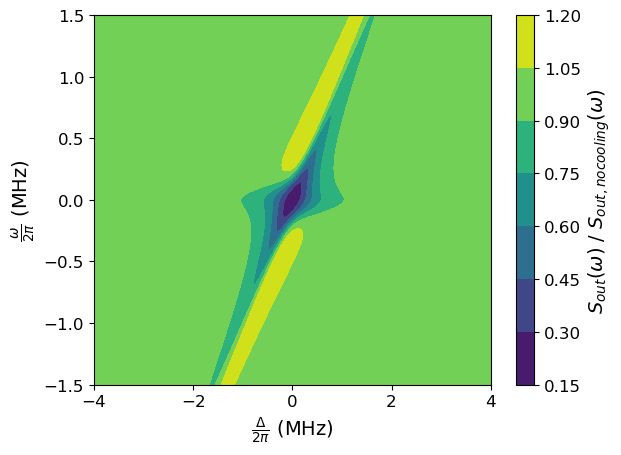

In [15]:
# And plot
plt.contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec / output_spec_no_cooling)
plt.xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
plt.ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.colorbar(label="$S_{out}(\\omega)$ / $S_{out, no cooling}(\\omega)$")